In [1]:
import os
os.chdir('../../../')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter4/Ch4_NOVEL.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

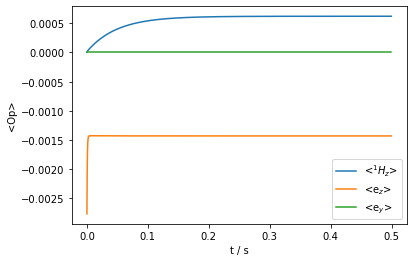

In [2]:
ex=sl.ExpSys(v0H=14,Nucs=['1H','e'],vr=0,LF=[True,False],T_K=80,pwdavg=sl.PowderAvg()[10])
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-1e4,Ayy=-1e4,Azz=2e4)

L=ex.Liouvillian()
L.add_relax('T1',i=0,T1=.1,OS=True,Thermal=True)
L.add_relax('T2',i=0,T2=.005,OS=True)
L.add_relax('T1',i=1,T1=.0014,OS=True,Thermal=True)
L.add_relax('T2',i=1,T2=10e-6,OS=True)

v1=14e6
pi2=1/v1/4
SL=5e-6
RD=.5e-3

seq=L.Sequence().add_channel('e',t=[0,pi2,pi2+SL,2*pi2+SL,RD],v1=[v1,v1,v1,0],phase=[0,np.pi/2,np.pi,0])

rho=sl.Rho('Thermal',['1Hz','ez','ey'])
rho.DetProp(seq,n=1000)

rho.plot(axis='s')

[<AxesSubplot:ylabel='$v_1$ / kHz'>,
 <AxesSubplot:xlabel='t / $\\mu$s', ylabel='$v_1$ / kHz'>]

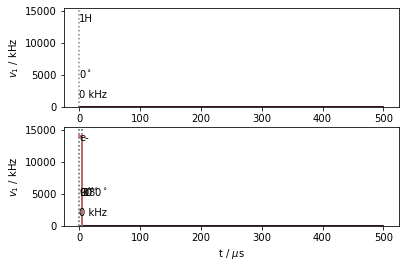

In [3]:
seq.plot()

In [4]:
rho.I[0][-1]/ex.Peq[0]

(147.80291978123492+6.954261420263472e-09j)

Prop: 1000 steps per every 1 rotor period


<AxesSubplot:xlabel='t / ms', ylabel='<Op>'>

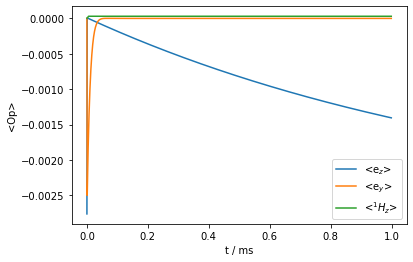

In [5]:
ex=sl.ExpSys(v0H=14,Nucs=['1H','e'],vr=1000,LF=[True,False],T_K=80,pwdavg=sl.PowderAvg()[10])
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-1e4,Ayy=-1e4,Azz=2e4)

L=ex.Liouvillian()
L.add_relax('T1',i=0,T1=.1,OS=True,Thermal=True)
L.add_relax('T2',i=0,T2=.005,OS=True)
L.add_relax('T1',i=1,T1=.0014,OS=True,Thermal=True)
L.add_relax('T2',i=1,T2=10e-6,OS=True)

v1=14e6
pi2=1/v1/4
SL=5e-6
RD=L.taur-SL-pi2

seq=L.Sequence().add_channel('e',t=[0,pi2,pi2+SL,pi2+SL+RD],v1=[v1,v1,0],phase=[0,np.pi/2,0])

rho=sl.Rho('Thermal',['ez','ey','1Hz'])
rho.DetProp(seq,n=1000,n_per_seq=1000)

rho.plot(axis='ms')

In [18]:
pi2

1.7857142857142856e-08